In [185]:
import numpy as np
import pandas as pd

In [186]:
import os
import tarfile
import urllib.request
import ssl

DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

# Create an SSL context to bypass SSL verification
context = ssl._create_unverified_context()

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            print(f"Downloading {url}...")
            with urllib.request.urlopen(url, context=context) as response, open(path, 'wb') as out_file:
                out_file.write(response.read())  # ✅ Save to disk
        with tarfile.open(path) as tar_bz2_file:
            tar_bz2_file.extractall(path=spam_path)
            print(f"Extracted {filename} to {spam_path}")

fetch_spam_data()


/var/folders/1q/dnpwvw112w7bxtjst50whx0r0000gn/T/ipykernel_73321/3145966879.py:24: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


Extracted ham.tar.bz2 to datasets/spam
Extracted spam.tar.bz2 to datasets/spam


In [187]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [188]:
len(spam_filenames)

500

In [189]:
len(ham_filenames)

2500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [190]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [191]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

To get a feel how our emails look like :

## Get a look at structure of email

In [192]:
print(spam_emails[3].get_content().strip())

##################################################
#                                                #
#                 Adult Club                     #
#           Offers FREE Membership               #
#                                                #
##################################################

>>>>>  INSTANT ACCESS TO ALL SITES NOW
>>>>>  Your User Name And Password is.
>>>>>  User Name: zzzz@spamassassin.taint.org
>>>>>  Password: 760382

5 of the Best Adult Sites on the Internet for FREE!
---------------------------------------
NEWS 08/18/02
With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New
Members. Are you one of them yet???
---------------------------------------
Our Membership FAQ

Q. Why are you offering free access to 5 adult membership sites for free?
A. I have advertisers that pay me for ad space so you don't have to pay for membership.

Q. Is it true my membership is for life?
A. Absolutely you'll never have to pay a cen

In [193]:
print(ham_emails[6].get_content().strip())

The Scotsman - 22 August 2002

 Playboy wants to go out with a bang 
 
 
 AN AGEING Berlin playboy has come up with an unusual offer to lure women into
 his bed - by promising the last woman he sleeps with an inheritance of 250,000
 (£160,000). 
 
 Rolf Eden, 72, a Berlin disco owner famous for his countless sex partners,
 said he could imagine no better way to die than in the arms of an attractive
 young woman - preferably under 30. 
 
 "I put it all in my last will and testament - the last woman who sleeps with
 me gets all the money," Mr Eden told Bild newspaper. 
 
 "I want to pass away in the most beautiful moment of my life. First a lot of
 fun with a beautiful woman, then wild sex, a final orgasm - and it will all
 end with a heart attack and then Im gone." 
 
 Mr Eden, who is selling his nightclub this year, said applications should be
 sent in quickly because of his age. "It could end very soon," he said.


------------------------ Yahoo! Groups Sponsor ---------------------~

In [194]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [195]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [196]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [197]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [198]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

### Preparing to load data using pandas

In [199]:
import os
import pandas as pd

HAM_PATH = os.path.join("datasets", "spam", "easy_ham")
SPAM_PATH = os.path.join("datasets", "spam", "spam")

ham_files = [os.path.join(HAM_PATH, f) for f in os.listdir(HAM_PATH)]
spam_files = [os.path.join(SPAM_PATH, f) for f in os.listdir(SPAM_PATH)]

print(f"Number of ham files: {len(ham_files)}")
print(f"Number of spam files: {len(spam_files)}")


Number of ham files: 2501
Number of spam files: 501


## Load the Data

In [200]:
def load_email(file_path):
    with open(file_path, 'r', encoding='latin1') as file:
        return file.read()

# Load data
ham_data = [(load_email(file), "ham") for file in ham_files]
spam_data = [(load_email(file), "spam") for file in spam_files]

# Create DataFrame
df = pd.DataFrame(ham_data + spam_data, columns=["email", "label"])

print(df.head())


                                               email label
0  From fork-admin@xent.com  Tue Sep 24 17:55:30 ...   ham
1  From rpm-list-admin@freshrpms.net  Mon Sep  9 ...   ham
2  From secprog-return-625-jm=jmason.org@security...   ham
3  Return-Path: nas@python.ca\nDelivery-Date: Thu...   ham
4  From fork-admin@xent.com  Thu Aug 29 11:03:51 ...   ham


In [201]:
print(type(ham_data))

<class 'list'>


### A quick look at the data structure

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   3002 non-null   object
 1   label   3002 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [203]:
df.dtypes

email    object
label    object
dtype: object

In [204]:
c=df.mean(numeric_only=True)
c

Series([], dtype: float64)

In [205]:
df['label'].value_counts()

label
ham     2501
spam     501
Name: count, dtype: int64

Unblanced dataset

In [206]:
df.describe()

,email,label
count,3002,3002
unique,3002,2
top,From fork-admin@xent.com Tue Sep 24 17:55:30 ...,ham
freq,1,2501


Visualising the amount by which dataset is unbalanced

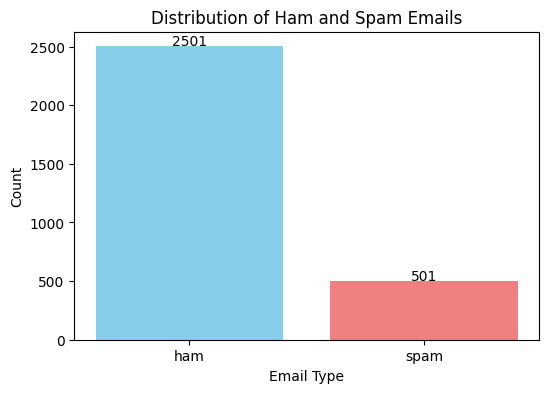

In [207]:
import matplotlib.pyplot as plt
#Count the number of ham and spam emails
label_counts = df['label'].value_counts()

# Plot the histogram
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral'])

# Add labels and title
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Ham and Spam Emails')
# Display values on top of bars
for i, value in enumerate(label_counts.values):
    plt.text(i, value + 5, str(value), ha='center')

plt.show()


## Create a test set

In [208]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(df,df['label']):
    strat_train_set=df.loc[train_index]
    strat_test_set=df.loc[test_index]
    

In [209]:
# Print results
print("Train Set:")
print(strat_train_set["label"].value_counts(normalize=True))  # Check label distribution
print("\nTest Set:")
print(strat_test_set["label"].value_counts(normalize=True))  # Check label distribution


Train Set:
label
ham     0.832986
spam    0.167014
Name: proportion, dtype: float64

Test Set:
label
ham     0.833611
spam    0.166389
Name: proportion, dtype: float64


# Possible EDA FOR:
- email length
- common words
- presence of special characters and numbers
- word count and average word length

In [210]:
mails = strat_train_set.copy()
test_mails = strat_test_set.copy()

## Exploratory Data Analysis

In [211]:
mails.head()

,email,label
1211,From sentto-2242572-55982-1034029763-zzzz=spam...,ham
2865,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,spam
2389,From rssfeeds@jmason.org Thu Sep 26 16:42:14 ...,ham
1232,From rssfeeds@jmason.org Sun Oct 6 22:54:50 ...,ham
2679,From ilug-admin@linux.ie Sat Sep 7 22:05:55 ...,spam


In [212]:
ham_email_lengths = mails.loc[strat_train_set["label"] == "ham", "email"].apply(len)
print("Average email length :",sum(ham_email_lengths)/len(ham_email_lengths))  # Prints average length of ham emails
print("max email lenghth of spam emails :" , max(ham_email_lengths)) 
print("min email lenghth of spam emails :" , min(ham_email_lengths)) 

Average email length : 3567.2285
max email lenghth of spam emails : 202500
min email lenghth of spam emails : 493


In [213]:
spam_email_lengths = mails.loc[strat_train_set["label"] == "spam", "email"].apply(len)
print("Average email length :" , sum(spam_email_lengths)/len(spam_email_lengths))  # Prints average length of ham emails
print("max email lenghth of spam emails :" , max(spam_email_lengths))  
print("min email lenghth of spam emails :" , min(spam_email_lengths)) 

Average email length : 6479.30174563591
max email lenghth of spam emails : 185722
min email lenghth of spam emails : 868


In [214]:
mails.isna().sum() 

email    0
label    0
dtype: int64

## No NULL values

### Special characters count in ham and spam

In [215]:
import re
def count_special(s):
    return len(re.findall(r'[^a-zA-Z0-9\s]', s))

In [216]:
mails['special_char_count'] = mails['email'].apply(count_special)
mails['special_char_count']


1211     503
2865     151
2389     142
1232     173
2679    1034
        ... 
526       52
1326     564
1845     497
1992     121
1711     200
Name: special_char_count, Length: 2401, dtype: int64

In [217]:
spam_len= mails.loc[mails['label'] == 'spam', 'special_char_count'] 
print("Maximum number of special characters in spam : ",(spam_len).max())
print("Minimum number of special characters in spam : ",(spam_len).min())
print("Average number of special characters in spam : ",round((spam_len).mean(),2))

Maximum number of special characters in spam :  5852
Minimum number of special characters in spam :  117
Average number of special characters in spam :  803.02


In [218]:
ham_len= mails.loc[mails['label'] == 'ham', 'special_char_count'] 
print("Maximum number of special characters in spam : ",(ham_len).max())
print("Minimum number of special characters in spam : ",(ham_len).min())
print("Average number of special characters in spam : ",round((ham_len).mean(),2))

Maximum number of special characters in spam :  8396
Minimum number of special characters in spam :  46
Average number of special characters in spam :  420.04


### Most common words

In [219]:
from collections import Counter
import re

def most_common_word(text):
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words, ignoring case
    word_counts = Counter(words)
    return word_counts.most_common(1)[0]  # Returns most common word and its count

In [220]:
mails['most commmon word']= mails['email'].apply(most_common_word)
most_common_in_spam= mails.loc[mails['label'] == 'spam', 'most commmon word']
most_common_in_spam

2865          (org, 5)
2679           (b, 19)
2766         (the, 23)
2582         (3d, 143)
2702    (localhost, 6)
             ...      
2647         (com, 34)
2993         (3d, 193)
2556        (font, 32)
2866         (com, 11)
2750         (from, 8)
Name: most commmon word, Length: 401, dtype: object

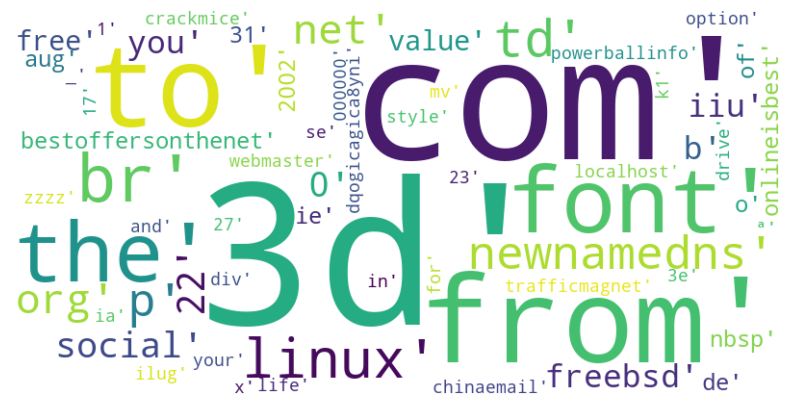

In [221]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all most common words in spam emails
spam_words = ' '.join(mails.loc[mails['label'] == 'spam', 'most commmon word'].astype(str))

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.show()


In [222]:
mails['most commmon word']= mails['email'].apply(most_common_word)
most_common_in_ham= mails.loc[mails['label'] == 'ham', 'most commmon word'] 
most_common_in_ham

1211    (com, 25)
2389    (org, 10)
1232    (org, 11)
2310    (net, 27)
1509    (com, 27)
          ...    
526      (cvs, 5)
1326    (net, 25)
1845    (the, 75)
1992       (i, 8)
1711    (org, 10)
Name: most commmon word, Length: 2000, dtype: object

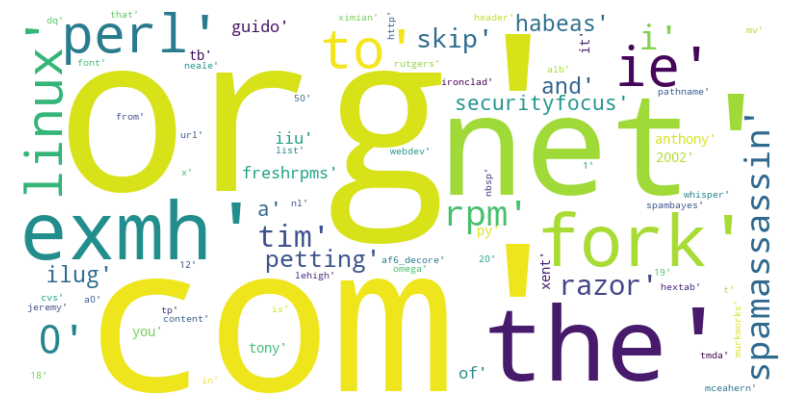

In [223]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all most common words in spam emails
ham_words = ' '.join(mails.loc[mails['label'] == 'ham', 'most commmon word'].astype(str))

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.show()

## Advanced analysis

### Stop words removal

In [224]:
import nltk
from nltk.corpus import stopwords
import string


# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratiibhas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [225]:
def remove_stopwords(text):
    """Removes stopwords and punctuation from a given text."""
    if isinstance(text, str):  # Ensure input is a string
        words = text.split()  # Tokenize the text
        filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
        return " ".join(filtered_words)  # Join words back into a string
    return text  # Return original if not a string

In [226]:
mails['cleaned_text']=mails['email'].apply(remove_stopwords)
mails

,email,label,special_char_count,most commmon word,cleaned_text
1211,From sentto-2242572-55982-1034029763-zzzz=spam...,ham,503,"(com, 25)",sentto-2242572-55982-1034029763-zzzz=spamassas...
2865,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,spam,151,"(org, 5)",Return-Path: ler@lerami.lerctr.org Delivery-Da...
2389,From rssfeeds@jmason.org Thu Sep 26 16:42:14 ...,ham,142,"(org, 10)",rssfeeds@jmason.org Thu Sep 26 16:42:14 2002 R...
1232,From rssfeeds@jmason.org Sun Oct 6 22:54:50 ...,ham,173,"(org, 11)",rssfeeds@jmason.org Sun Oct 6 22:54:50 2002 Re...
2679,From ilug-admin@linux.ie Sat Sep 7 22:05:55 ...,spam,1034,"(b, 19)",ilug-admin@linux.ie Sat Sep 7 22:05:55 2002 Re...
...,...,...,...,...,...
526,Return-Path: skip@pobox.com\nDelivery-Date: Sa...,ham,52,"(cvs, 5)",Return-Path: skip@pobox.com Delivery-Date: Sat...
1326,From spamassassin-devel-admin@lists.sourceforg...,ham,564,"(net, 25)",spamassassin-devel-admin@lists.sourceforge.net...
1845,From fork-admin@xent.com Mon Sep 23 18:32:22 ...,ham,497,"(the, 75)",fork-admin@xent.com Mon Sep 23 18:32:22 2002 R...
1992,Return-Path: guido@python.org\nDelivery-Date: ...,ham,121,"(i, 8)",Return-Path: guido@python.org Delivery-Date: M...


### Bigrams

In [227]:
from nltk.util import ngrams

In [228]:
def get_bigrams(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase
    bigrams = list(ngrams(tokens, 2))  # Generate bigrams
    return ["_".join(bigram) for bigram in bigrams]  # Join words with "_

In [229]:
mails['bigrams_before_cleaning'] = mails['email'].apply(get_bigrams)
mails['bigrams_after_cleaning'] = mails['cleaned_text'].apply(get_bigrams)
mails

,email,label,special_char_count,most commmon word,cleaned_text,bigrams_before_cleaning,bigrams_after_cleaning
1211,From sentto-2242572-55982-1034029763-zzzz=spam...,ham,503,"(com, 25)",sentto-2242572-55982-1034029763-zzzz=spamassas...,[from_sentto-2242572-55982-1034029763-zzzz=spa...,[sentto-2242572-55982-1034029763-zzzz=spamassa...
2865,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,spam,151,"(org, 5)",Return-Path: ler@lerami.lerctr.org Delivery-Da...,"[return-path_:, :_ler, ler_@, @_lerami.lerctr....","[return-path_:, :_ler, ler_@, @_lerami.lerctr...."
2389,From rssfeeds@jmason.org Thu Sep 26 16:42:14 ...,ham,142,"(org, 10)",rssfeeds@jmason.org Thu Sep 26 16:42:14 2002 R...,"[from_rssfeeds, rssfeeds_@, @_jmason.org, jmas...","[rssfeeds_@, @_jmason.org, jmason.org_thu, thu..."
1232,From rssfeeds@jmason.org Sun Oct 6 22:54:50 ...,ham,173,"(org, 11)",rssfeeds@jmason.org Sun Oct 6 22:54:50 2002 Re...,"[from_rssfeeds, rssfeeds_@, @_jmason.org, jmas...","[rssfeeds_@, @_jmason.org, jmason.org_sun, sun..."
2679,From ilug-admin@linux.ie Sat Sep 7 22:05:55 ...,spam,1034,"(b, 19)",ilug-admin@linux.ie Sat Sep 7 22:05:55 2002 Re...,"[from_ilug-admin, ilug-admin_@, @_linux.ie, li...","[ilug-admin_@, @_linux.ie, linux.ie_sat, sat_s..."
...,...,...,...,...,...,...,...
526,Return-Path: skip@pobox.com\nDelivery-Date: Sa...,ham,52,"(cvs, 5)",Return-Path: skip@pobox.com Delivery-Date: Sat...,"[return-path_:, :_skip, skip_@, @_pobox.com, p...","[return-path_:, :_skip, skip_@, @_pobox.com, p..."
1326,From spamassassin-devel-admin@lists.sourceforg...,ham,564,"(net, 25)",spamassassin-devel-admin@lists.sourceforge.net...,"[from_spamassassin-devel-admin, spamassassin-d...","[spamassassin-devel-admin_@, @_lists.sourcefor..."
1845,From fork-admin@xent.com Mon Sep 23 18:32:22 ...,ham,497,"(the, 75)",fork-admin@xent.com Mon Sep 23 18:32:22 2002 R...,"[from_fork-admin, fork-admin_@, @_xent.com, xe...","[fork-admin_@, @_xent.com, xent.com_mon, mon_s..."
1992,Return-Path: guido@python.org\nDelivery-Date: ...,ham,121,"(i, 8)",Return-Path: guido@python.org Delivery-Date: M...,"[return-path_:, :_guido, guido_@, @_python.org...","[return-path_:, :_guido, guido_@, @_python.org..."


### TF-IDF Analysis (Important words)

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [231]:
vectorizer = TfidfVectorizer()  # You can set ngram_range=(1,2) for unigrams & bigrams
tfidf_matrix = vectorizer.fit_transform(mails['cleaned_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display TF-IDF values
print(tfidf_df) # The higher values shows higher importance of that word


            00       000      0000  000000  000000000  000000000000000000000  \
0     0.032948  0.000000  0.087904     0.0        0.0                    0.0   
1     0.000000  0.000000  0.000000     0.0        0.0                    0.0   
2     0.000000  0.000000  0.031718     0.0        0.0                    0.0   
3     0.075059  0.000000  0.028607     0.0        0.0                    0.0   
4     0.000000  0.000000  0.000000     0.0        0.0                    0.0   
...        ...       ...       ...     ...        ...                    ...   
2396  0.031299  0.000000  0.000000     0.0        0.0                    0.0   
2397  0.019300  0.000000  0.000000     0.0        0.0                    0.0   
2398  0.013644  0.047781  0.000000     0.0        0.0                    0.0   
2399  0.043576  0.000000  0.000000     0.0        0.0                    0.0   
2400  0.046687  0.000000  0.026691     0.0        0.0                    0.0   

      00000053  0000006f  00000094  000

### For Ham emails

In [232]:
# Ensure indices match between `mails` and `tfidf_df`
mails = mails.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)

# Now, filter ham indices correctly
ham_indices = mails[mails['label'] == 'ham'].index  # Get correct indices
ham_tfidf = tfidf_df.loc[ham_indices]  # No KeyError should occur


# Get top words for each ham mail
for i, row in ham_tfidf.iterrows():
    top_words = row.sort_values(ascending=False).head(3).index.tolist()  # Top 3 words
    print(f"Top words for Ham Mail {i+1}: {top_words}")


Top words for Ham Mail 1: ['yahoo', 'zzzzteana', 'scd']
Top words for Ham Mail 3: ['jwz', 'g8qfvzg25032', '48393']
Top words for Ham Mail 4: ['programmers', 'g96805k15046', 'sun']
Top words for Ham Mail 6: ['talk', 'habeas', 'sourceforge']
Top words for Ham Mail 7: ['fork', 'ebuilt', 'xent']
Top words for Ham Mail 8: ['aicn', 'g9181ak15555', 'oct']
Top words for Ham Mail 9: ['tied', 'times', 'tim']
Top words for Ham Mail 10: ['powell', 'companies', 'telecom']
Top words for Ham Mail 11: ['xent', 'fork', 'slack']
Top words for Ham Mail 12: ['devel', 'sourceforge', 'habeas']
Top words for Ham Mail 13: ['wallace', 'bigfoot', 'dec']
Top words for Ham Mail 14: ['devel', 'sourceforge', 'luth']
Top words for Ham Mail 15: ['xent', 'fork', 'leitl']
Top words for Ham Mail 16: ['g92830k31815', 'mac', 'oct']
Top words for Ham Mail 18: ['razor', 'sourceforge', 'vipul']
Top words for Ham Mail 19: ['exmh', 'stortek', 'users']
Top words for Ham Mail 20: ['reject', 'local_scan', 'exim4']
Top words for H

### For Spam emails

In [233]:
# Now, filter ham indices correctly
spam_indices = mails[mails['label'] == 'spam'].index  # Get correct indices
spam_tfidf = tfidf_df.loc[spam_indices]  # No KeyError should occur


# Get top words for each ham mail
for i, row in spam_tfidf.iterrows():
    top_words = row.sort_values(ascending=False).head(3).index.tolist()  # Top 3 words
    print(f"Top words for spam Mail {i+1}: {top_words}")


Top words for spam Mail 2: ['lerami', 'lerctr', 'g8bhyte9023507']
Top words for spam Mail 5: ['ilug', 'ie', 'linux']
Top words for spam Mail 17: ['young', 'black', 'america']
Top words for spam Mail 28: ['3d', 'runbox', '______________________________________________________________________']
Top words for spam Mail 31: ['ad3ae071', '_nextpart_000_0044_5a8512d6', 'paychecks4life']
Top words for spam Mail 44: ['3d', 'font', '0px']
Top words for spam Mail 53: ['domain', 'susan_brown', 'excite']
Top words for spam Mail 55: ['freebsd', 'black', 'african']
Top words for spam Mail 80: ['tammy490t', 'fees', 'yahoo']
Top words for spam Mail 111: ['webmake', 'sourceforge', 'talk']
Top words for spam Mail 112: ['31', '30', 'cbubrookie69']
Top words for spam Mail 116: ['ilug', 'ie', 'linux']
Top words for spam Mail 119: ['font', 'td', 'tr']
Top words for spam Mail 132: ['improvement', 'andijeanehuaa', 'dieting']
Top words for spam Mail 133: ['report', '000', 'mails']
Top words for spam Mail 137: 

## Building a machine learning model

In [247]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
strat_train_set['label'] = le.fit_transform(strat_train_set['label'])  # 'ham' → 0, 'spam' → 1
y =strat_train_set['label']
strat_test_set['label'] = le.fit_transform(strat_test_set['label'])  # 'ham' → 0, 'spam' → 1
y =strat_test_set['label']



In [248]:
x_test= strat_test_set.drop(columns=['label'])
y_test= strat_test_set['label']

In [249]:
x_train= strat_train_set.drop(columns=['label'])
y_train= strat_train_set['label']
y_train = y_train.ravel()  # Convert DataFrame column to 1D array


/var/folders/1q/dnpwvw112w7bxtjst50whx0r0000gn/T/ipykernel_73321/640111706.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()  # Convert DataFrame column to 1D array


### Training and prediction

In [250]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(x_train.iloc[:, 0].astype(str).tolist())  # Convert first column to list of strings

print("Shape of X_train_tfidf:", X_train_tfidf.shape)


Shape of X_train_tfidf: (2401, 75567)


NAIVE BAYES

In [251]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Model trained successfully!")


Model trained successfully!


In [252]:
from sklearn.metrics import classification_report, accuracy_score
# 1️⃣ Transform x_test using the same vectorizer
X_test_tfidf = vectorizer.transform(x_test.iloc[:, 0].astype(str).tolist()) 

# 2️⃣ Predict using the trained model
y_pred = nb_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       501
           1       1.00      0.40      0.57       100

    accuracy                           0.90       601
   macro avg       0.95      0.70      0.76       601
weighted avg       0.91      0.90      0.88       601

Accuracy: 0.9001663893510815


USING LOGISTIC REGRESSION

In [254]:
from sklearn.linear_model import LogisticRegression
lg_clf = LogisticRegression()
lg_clf.fit(X_train_tfidf, y_train)
print("Model trained successfully!")


Model trained successfully!


In [255]:
X_test_tfidf = vectorizer.transform(x_test.iloc[:, 0].astype(str).tolist()) 

# 2️⃣ Predict using the trained model
y_pred = lg_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       501
           1       0.98      0.93      0.95       100

    accuracy                           0.99       601
   macro avg       0.98      0.96      0.97       601
weighted avg       0.98      0.99      0.98       601

Accuracy: 0.9850249584026622
